# Implementation of SRGAN

In [203]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

import tensorflow as tf
import keras

from keras import layers, Model
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from tensorflow.keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add, Dropout
from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications import MobileNetV2, VGG19, EfficientNetB0, VGG16

from sklearn.model_selection import train_test_split

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# turn on mixed precision training
mixed_precision.set_global_policy('mixed_float16') # set global data policy to mixed precision

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5


## Building the Generator

In [97]:
#Define blocks to build the generator

def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(128, (1,1), padding = "same")(res_model)
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

In [98]:
def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)

    return up_model

In [211]:
#Generator model

def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = Conv2D(64, (1,1), padding="same")(layers)
    layers = Conv2D(64, (7,7), padding="same")(layers)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)
    
    layers = Conv2D(64, (5,5), padding="same")(layers)
    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op, name='Generator')

## Building the Discriminator

In [187]:
#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization(momentum=0.8)(disc_model)
#         disc_model = BatchNormalization(momentum=0.5)(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model

In [208]:
#Descriminartor, as described in the original paper

def create_disc(disc_ip):

    df = 8
    
#     disc_ip = tf.keras.layers.Input(shape=(128, 128, 3,))
    disc_ip = tf.keras.layers.Input(shape=(384, 384, 3,))
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
#     d4 = discriminator_block(d3, df*2, strides=2)
#     d5 = discriminator_block(d4, df*4)
#     d6 = discriminator_block(d5, df*4, strides=2)
#     d7 = discriminator_block(d6, df*8)
#     d8 = discriminator_block(d7, df*8)
    
    d8_5 = Flatten()(d3)
    d9 = Dense(df*4)(d8_5)
    d9 = Dropout(0.2)(d9)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)
    
#     print(f"Validity: {validity}")

    return Model(disc_ip, validity, name='Discriminator')

In [102]:
#Descriminartor, as described in the original paper

def create_disc2(disc_ip):

    df = 64
    
    disc_ip = tf.keras.layers.Input(shape=(128, 128, 3,))
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8)
#     d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    print(d8_5)
    d9 = Dense(df*4)(d8_5)
    d9 = Dropout(0.1)(d9)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d8_5)
    
#     print(f"Validity: {validity}")

    return Model(disc_ip, validity)

In [119]:
agora_vai = tf.convert_to_tensor(np.random.rand(1, 128, 128, 3), dtype=float)

In [148]:
m = create_disc(agora_vai)
m(agora_vai)

<tf.Tensor: shape=(1, 1), dtype=float16, numpy=array([[0.4995]], dtype=float16)>

## Combined Model

In [209]:
def build_mobile(hr_shape):
    
    vgg = VGG16(weights="imagenet",include_top=False, input_shape=hr_shape)
#     vgg = EfficientNetB0(weights="imagenet",include_top=False, input_shape=hr_shape)[17]

    return Model(inputs=vgg.inputs, outputs=vgg.layers[9].output, name='VGG16')

In [216]:
#Combined model

def create_comb(gen_model, disc_model, mobile, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = mobile(gen_img)
    
    disc_model.trainable = False
    
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features], name='GAN_Model')

## Training

In [191]:
#Load first n number of images (to train on a subset of all images)
#For demo purposes, let us use 5000 images

n = 100

# lr_list = os.listdir("Data/lr_images/")[:n]
lr_list = os.listdir("Data/LR/")[:n]

lr_images = []
for img in lr_list:
#     img_lr = cv2.imread("Data/lr_images/" + img)
    img_lr = cv2.imread("Data/LR/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)
    
# hr_list = os.listdir("Data/hr_images/")[:n]
hr_list = os.listdir("Data/HR/")[:n]
   
hr_images = []
for img in hr_list:
#     img_hr = cv2.imread("Data/hr_images/" + img)
    img_hr = cv2.imread("Data/HR/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

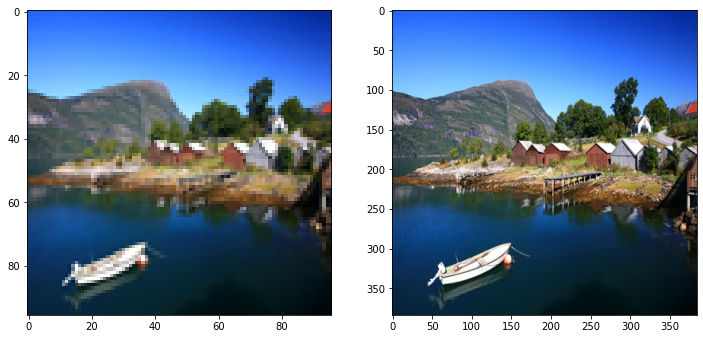

In [194]:
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(lr_images[image_number])
plt.subplot(122)
plt.imshow(hr_images[image_number])
plt.show()

## Generator Training Model 

In [230]:
#Split scaled values to train and test
# lr_images = lr_images / 255.
# hr_images = hr_images / 255.

lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images/255., hr_images/255., 
                                                      test_size=0.33, random_state=42)



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])
print(hr_shape)

lr_ip = Input(shape=lr_shape, name='low_resolution_input')
hr_ip = Input(shape=hr_shape, name='high_resolution_input')

generator = create_gen(lr_ip, num_res_block = 32)
generator.summary()

(384, 384, 3)
Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 low_resolution_input (InputLay  [(None, 96, 96, 3)]  0          []                               
 er)                                                                                              
                                                                                                  
 conv2d_1764 (Conv2D)           (None, 96, 96, 64)   15616       ['low_resolution_input[0][0]']   
                                                                                                  
 conv2d_1765 (Conv2D)           (None, 96, 96, 64)   4160        ['conv2d_1764[0][0]']            
                                                                                                  
 conv2d_1766 (Conv2D)           (None, 96, 96, 64)   200768      ['conv2d_17

## Discriminator Training Model

In [231]:
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer= tf.keras.optimizers.Adam(), metrics=['accuracy'])
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_47 (InputLayer)       [(None, 384, 384, 3)]     0         
                                                                 
 conv2d_1868 (Conv2D)        (None, 384, 384, 8)       224       
                                                                 
 leaky_re_lu_42 (LeakyReLU)  (None, 384, 384, 8)       0         
                                                                 
 conv2d_1869 (Conv2D)        (None, 192, 192, 8)       584       
                                                                 
 batch_normalization_1413 (B  (None, 192, 192, 8)      32        
 atchNormalization)                                              
                                                                 
 leaky_re_lu_43 (LeakyReLU)  (None, 192, 192, 8)       0         
                                                     

## VGG Model 

In [232]:
# vgg = build_mobile((128,128,3))
vgg = build_mobile((384,384,3))
print(vgg.summary())
vgg.trainable = False

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_48 (InputLayer)       [(None, 384, 384, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 384, 384, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 384, 384, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 192, 192, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 192, 192, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 192, 192, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 96, 96, 128)       0     

## GAN Model 

In [233]:
gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

In [234]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-6,1], optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
gan_model.summary()

Model: "GAN_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 low_resolution_input (InputLay  [(None, 96, 96, 3)]  0          []                               
 er)                                                                                              
                                                                                                  
 Generator (Functional)         (None, 384, 384, 3)  4988483     ['low_resolution_input[0][0]']   
                                                                                                  
 high_resolution_input (InputLa  [(None, 384, 384, 3  0          []                               
 yer)                           )]                                                                
                                                                                          

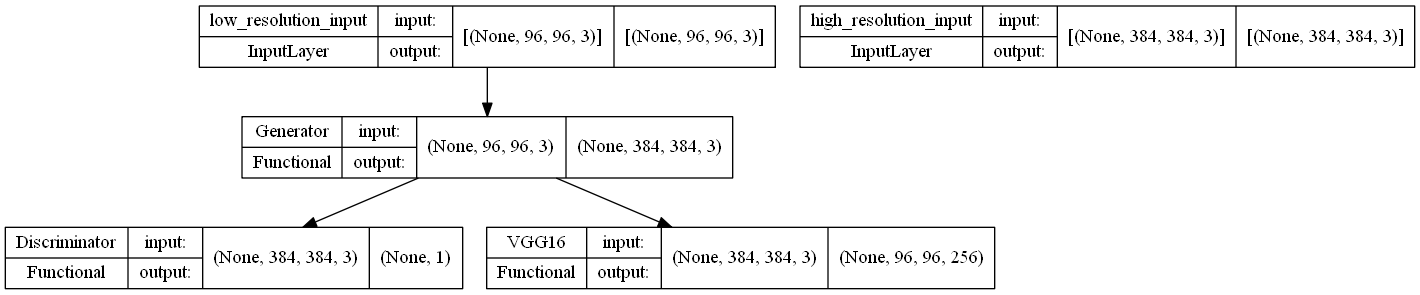

In [235]:
# plotting the embedded model
plot_model(gan_model, show_shapes=True)

In [241]:
#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
gen_losses = []
disc_losses = []

for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])
    
    
epochs = 50

#Enumerate training over epochs
for e in range(epochs):
    
    print("epoch:", e+1, end=' ')
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    gen_losses.append(g_loss)
    disc_losses.append(d_loss)
    
    #Report the progress during training. 
    print("g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")

epoch: 1 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:32<00:00,  1.39s/it]


g_loss: 21.381471548507463 d_loss: [0.82073246 0.5       ]
epoch: 2 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:31<00:00,  1.37s/it]


g_loss: 20.57258628731343 d_loss: [0.83076819 0.47014925]
epoch: 3 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:38<00:00,  1.48s/it]


g_loss: 19.965018656716417 d_loss: [0.82308687 0.46268657]
epoch: 4 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:33<00:00,  1.40s/it]


g_loss: 19.539995335820894 d_loss: [0.77896847 0.52238806]
epoch: 5 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:35<00:00,  1.43s/it]


g_loss: 19.060984141791046 d_loss: [0.79969993 0.48507463]
epoch: 6 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:32<00:00,  1.38s/it]


g_loss: 18.62051072761194 d_loss: [0.75866608 0.52238806]
epoch: 7 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:31<00:00,  1.37s/it]


g_loss: 18.21647621268657 d_loss: [0.75543486 0.54477612]
epoch: 8 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:31<00:00,  1.37s/it]


g_loss: 17.786847014925375 d_loss: [0.81564513 0.47014925]
epoch: 9 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:31<00:00,  1.37s/it]


g_loss: 17.302705223880597 d_loss: [0.79889007 0.51492537]
epoch: 10 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:31<00:00,  1.37s/it]

g_loss: 16.939190764925375 d_loss: [0.8209438  0.50746269]


epoch: 11 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:31<00:00,  1.37s/it]


g_loss: 16.50985307835821 d_loss: [0.82685351 0.5       ]
epoch: 12 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:34<00:00,  1.41s/it]


g_loss: 16.12395055970149 d_loss: [0.78266428 0.50746269]
epoch: 13 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:31<00:00,  1.37s/it]


g_loss: 15.798565764925373 d_loss: [0.78665389 0.54477612]
epoch: 14 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:33<00:00,  1.40s/it]


g_loss: 15.540345149253731 d_loss: [0.81364555 0.44029851]
epoch: 15 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:32<00:00,  1.38s/it]


g_loss: 15.208138992537313 d_loss: [0.81575445 0.51492537]
epoch: 16 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:31<00:00,  1.36s/it]


g_loss: 14.894123134328359 d_loss: [0.79406556 0.53731343]
epoch: 17 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:31<00:00,  1.37s/it]


g_loss: 14.589610541044776 d_loss: [0.77788942 0.59701493]
epoch: 18 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:31<00:00,  1.36s/it]


g_loss: 14.301014458955224 d_loss: [0.80349276 0.5       ]
epoch: 19 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:32<00:00,  1.38s/it]


g_loss: 14.099871735074627 d_loss: [0.76523009 0.52238806]
epoch: 20 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:32<00:00,  1.38s/it]

g_loss: 13.933039878731343 d_loss: [0.77284719 0.56716418]


epoch: 21 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:31<00:00,  1.37s/it]


g_loss: 13.629081156716419 d_loss: [0.81652559 0.5       ]
epoch: 22 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:31<00:00,  1.37s/it]


g_loss: 13.43837453358209 d_loss: [0.76516268 0.50746269]
epoch: 23 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:33<00:00,  1.40s/it]


g_loss: 13.29375583022388 d_loss: [0.80983632 0.50746269]
epoch: 24 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:33<00:00,  1.39s/it]


g_loss: 13.163596082089553 d_loss: [0.81270793 0.49253731]
epoch: 25 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:31<00:00,  1.37s/it]


g_loss: 13.131005130597014 d_loss: [0.82667109 0.47761194]
epoch: 26 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:31<00:00,  1.37s/it]


g_loss: 13.076813199626866 d_loss: [0.75536586 0.57462687]
epoch: 27 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:31<00:00,  1.37s/it]


g_loss: 13.120743936567164 d_loss: [0.80522862 0.53731343]
epoch: 28 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:31<00:00,  1.37s/it]


g_loss: 12.857567630597014 d_loss: [0.79543111 0.53731343]
epoch: 29 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:31<00:00,  1.37s/it]


g_loss: 12.548944729477611 d_loss: [0.80588884 0.51492537]
epoch: 30 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:32<00:00,  1.37s/it]

g_loss: 12.222218983208956 d_loss: [0.78714718 0.5       ]


epoch: 31 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:31<00:00,  1.37s/it]


g_loss: 11.922079057835822 d_loss: [0.79822666 0.47761194]
epoch: 32 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:35<00:00,  1.42s/it]


g_loss: 11.614855410447761 d_loss: [0.8203453  0.47761194]
epoch: 33 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:31<00:00,  1.36s/it]


g_loss: 11.420854710820896 d_loss: [0.78653068 0.51492537]
epoch: 34 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:31<00:00,  1.37s/it]


g_loss: 11.329757462686567 d_loss: [0.8243103  0.47014925]
epoch: 35 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:31<00:00,  1.37s/it]


g_loss: 11.211578824626866 d_loss: [0.80312814 0.52238806]
epoch: 36 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:36<00:00,  1.43s/it]


g_loss: 10.974609375 d_loss: [0.82754517 0.47014925]
epoch: 37 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:33<00:00,  1.40s/it]


g_loss: 10.914762126865671 d_loss: [0.79413161 0.48507463]
epoch: 38 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:33<00:00,  1.39s/it]


g_loss: 10.697265625 d_loss: [0.84101162 0.47761194]
epoch: 39 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:34<00:00,  1.41s/it]


g_loss: 10.650128264925373 d_loss: [0.82134144 0.47014925]
epoch: 40 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:33<00:00,  1.40s/it]

g_loss: 10.629605876865671 d_loss: [0.80583214 0.51492537]


epoch: 41 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:33<00:00,  1.40s/it]


g_loss: 10.504722481343284 d_loss: [0.82113329 0.49253731]
epoch: 42 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:33<00:00,  1.39s/it]


g_loss: 10.369752798507463 d_loss: [0.82718943 0.41791045]
epoch: 43 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:33<00:00,  1.40s/it]


g_loss: 10.131296641791044 d_loss: [0.78689256 0.46268657]
epoch: 44 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:33<00:00,  1.40s/it]


g_loss: 9.872201492537313 d_loss: [0.82703867 0.46268657]
epoch: 45 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:33<00:00,  1.39s/it]


g_loss: 9.700501399253731 d_loss: [0.83276048 0.53731343]
epoch: 46 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:33<00:00,  1.40s/it]


g_loss: 9.621909981343284 d_loss: [0.79265469 0.51492537]
epoch: 47 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:33<00:00,  1.39s/it]


g_loss: 9.626574160447761 d_loss: [0.82097523 0.51492537]
epoch: 48 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:33<00:00,  1.40s/it]


g_loss: 9.464348180970148 d_loss: [0.82442144 0.49253731]
epoch: 49 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:33<00:00,  1.39s/it]


g_loss: 9.348122667910447 d_loss: [0.87987279 0.44776119]
epoch: 50 

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:34<00:00,  1.41s/it]

g_loss: 9.32899953358209 d_loss: [0.83383361 0.5       ]


In [242]:
def interval_mapping(image, from_min, from_max, to_min, to_max):
    # map values from [from_min, from_max] to [to_min, to_max]
    # image: input array
    from_range = 1.0
    to_range = 255
    scaled = np.array((image - from_min) / float(from_range), dtype=float)
    return to_min + (scaled * to_range)

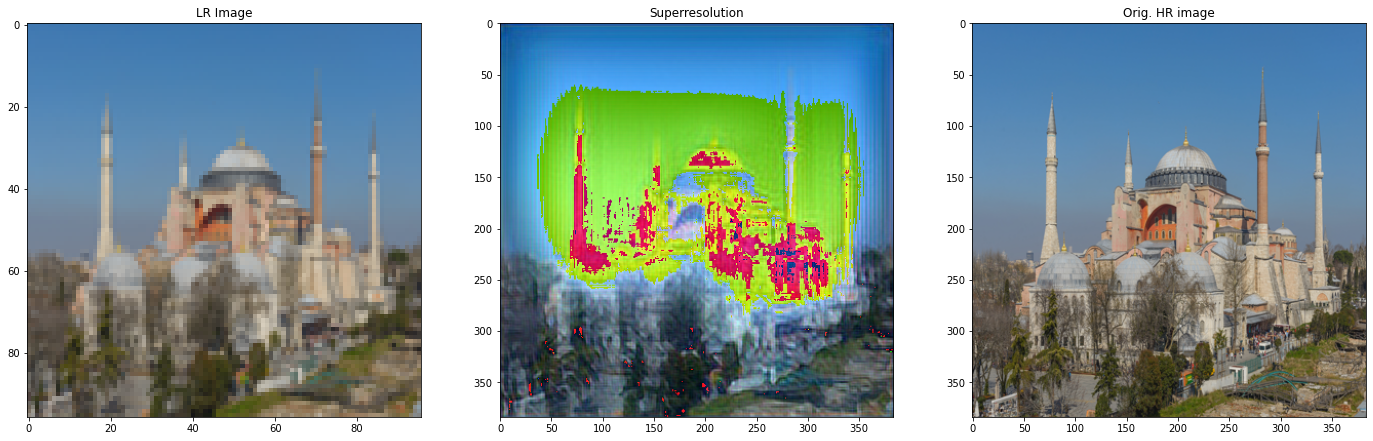

In [260]:
[X1, X2] = [lr_test, hr_test]
# select random example
ix = random.randint(0, len(X1))
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(tf.expand_dims(src_image, axis=0))

src_image = interval_mapping(src_image, 0.0, 1.0, 0, 255).astype('uint8')
tar_image = interval_mapping(tar_image, 0.0, 1.0, 0, 255).astype('uint8')
gen_image = interval_mapping(gen_image, 0.0, 1.0, 0, 255).astype('uint8')

# print(src_image)

# plot all three images

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image)

plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0])

plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image)

plt.show()

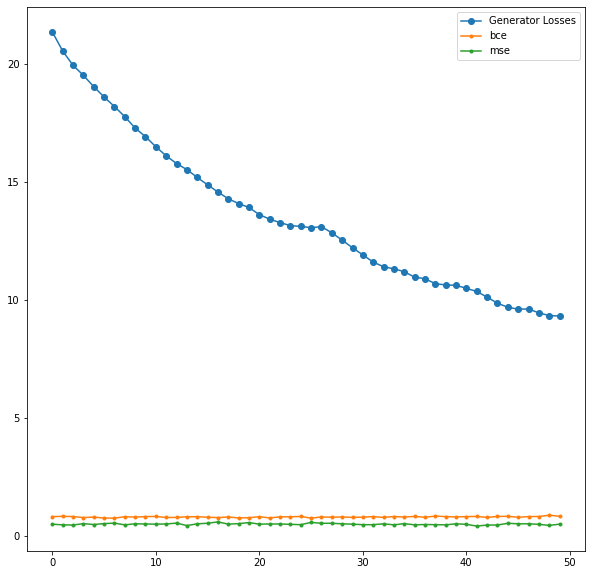

In [248]:
# 50 épocas

plt.figure(figsize=(10,10))
plt.plot(gen_losses, marker = 'o', label='Generator Losses')
plt.plot(disc_losses, marker = '.', label=['bce','mse'])
plt.legend()
plt.show()

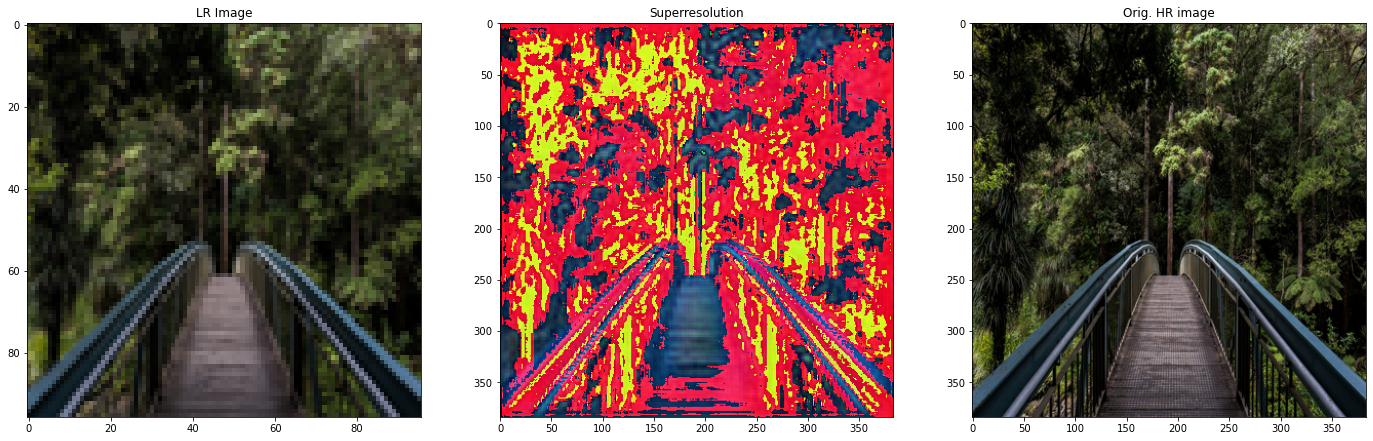

In [240]:
[X1, X2] = [lr_test, hr_test]
# select random example
ix = random.randint(0, len(X1))
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(tf.expand_dims(src_image, axis=0))

src_image = interval_mapping(src_image, 0.0, 1.0, 0, 255).astype('uint8')
tar_image = interval_mapping(tar_image, 0.0, 1.0, 0, 255).astype('uint8')
gen_image = interval_mapping(gen_image, 0.0, 1.0, 0, 255).astype('uint8')

# print(src_image)

# plot all three images

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image)

plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0])

plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image)

plt.show()

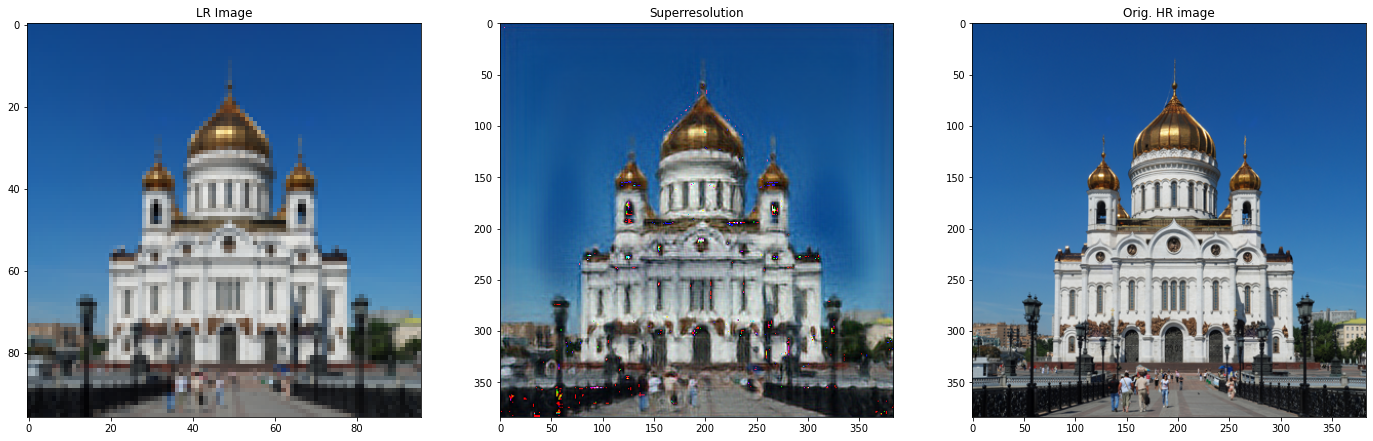

In [139]:
[X1, X2] = [lr_test, hr_test]
# select random example
ix = random.randint(0, len(X1))
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(tf.expand_dims(src_image, axis=0))

src_image = interval_mapping(src_image, 0.0, 1.0, 0, 255).astype('uint8')
tar_image = interval_mapping(tar_image, 0.0, 1.0, 0, 255).astype('uint8')
gen_image = interval_mapping(gen_image, 0.0, 1.0, 0, 255).astype('uint8')

# print(src_image)

# plot all three images

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image)

plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0])

plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image)

plt.show()

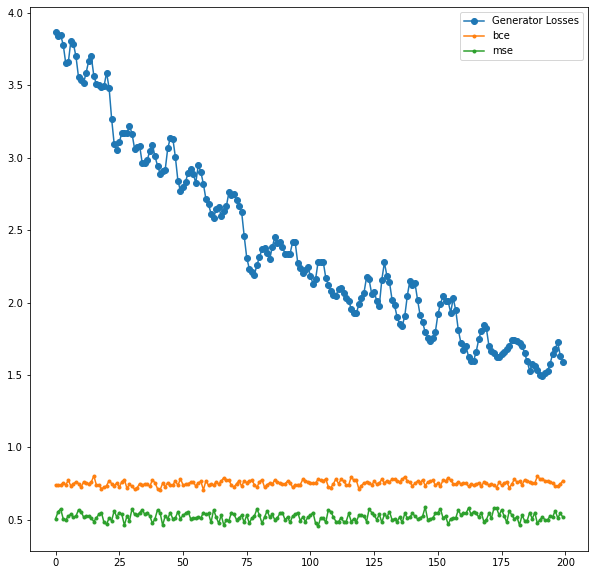

In [140]:
# 200 épocas

plt.figure(figsize=(10,10))
plt.plot(gen_losses, marker = 'o', label='Generator Losses')
plt.plot(disc_losses, marker = '.', label=['bce','mse'])
plt.legend()
plt.show()

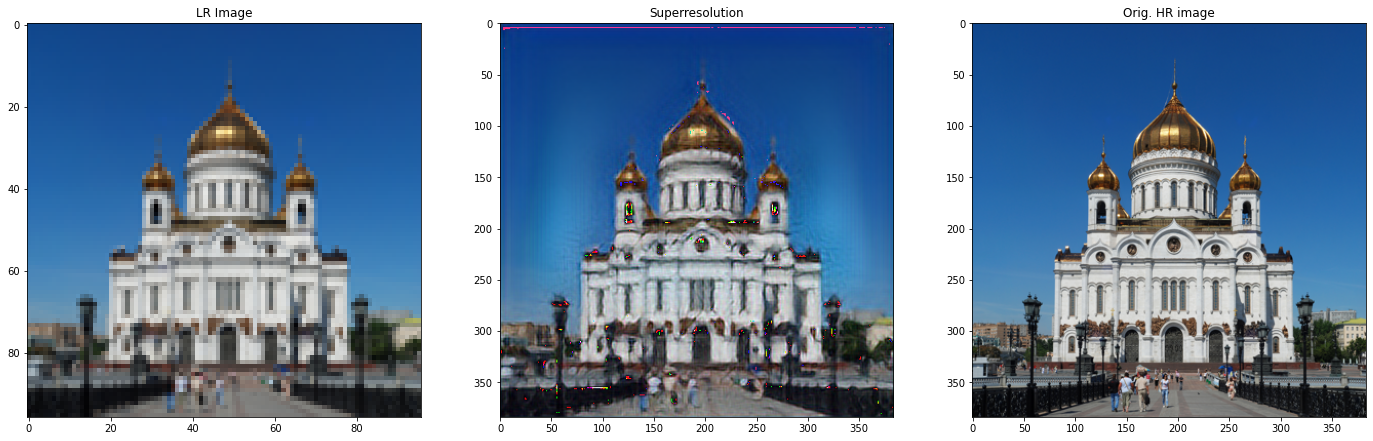

In [132]:
[X1, X2] = [lr_test, hr_test]
# select random example
ix = random.randint(0, len(X1))
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(tf.expand_dims(src_image, axis=0))

src_image = interval_mapping(src_image, 0.0, 1.0, 0, 255).astype('uint8')
tar_image = interval_mapping(tar_image, 0.0, 1.0, 0, 255).astype('uint8')
gen_image = interval_mapping(gen_image, 0.0, 1.0, 0, 255).astype('uint8')

# print(src_image)

# plot all three images

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image)

plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0])

plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image)

plt.show()

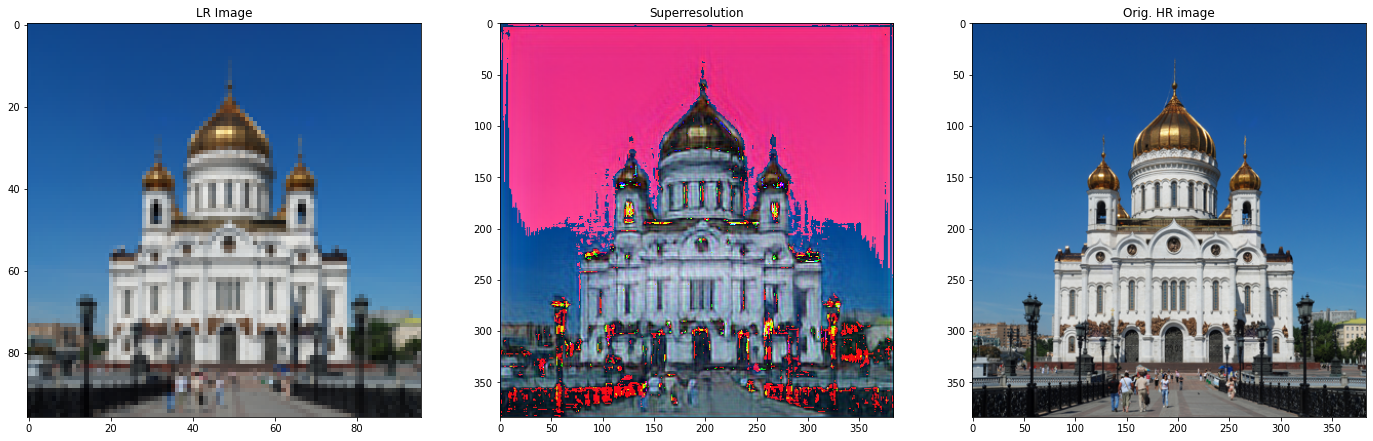

In [125]:
[X1, X2] = [lr_test, hr_test]
# select random example
ix = random.randint(0, len(X1))
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(tf.expand_dims(src_image, axis=0))

src_image = interval_mapping(src_image, 0.0, 1.0, 0, 255).astype('uint8')
tar_image = interval_mapping(tar_image, 0.0, 1.0, 0, 255).astype('uint8')
gen_image = interval_mapping(gen_image, 0.0, 1.0, 0, 255).astype('uint8')

# print(src_image)

# plot all three images

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image)

plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0])

plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image)

plt.show()

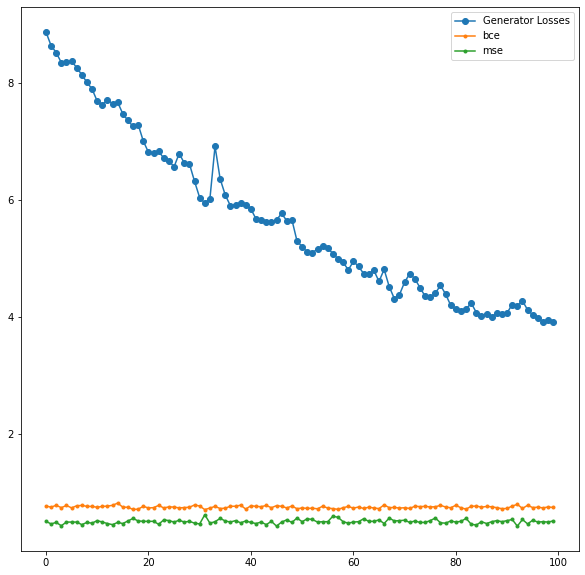

In [133]:
# 100 épocas

plt.figure(figsize=(10,10))
plt.plot(gen_losses, marker = 'o', label='Generator Losses')
plt.plot(disc_losses, marker = '.', label=['bce','mse'])
plt.legend()
plt.show()

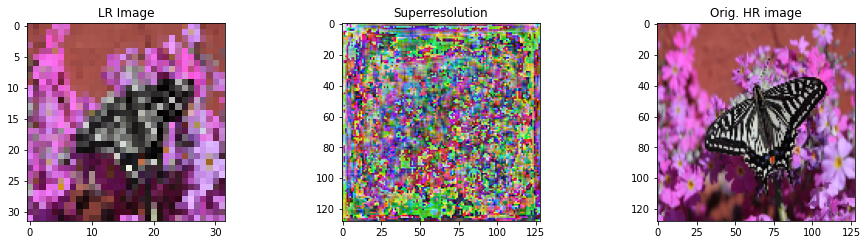

In [50]:
# generator = load_model('gen_e_3.h5', compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example
ix = random.randint(0, len(X1))
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(tf.expand_dims(src_image, axis=0))

src_image = interval_mapping(src_image, 0.0, 1.0, 0, 255).astype('uint8')
tar_image = interval_mapping(tar_image, 0.0, 1.0, 0, 255).astype('uint8')
gen_image = interval_mapping(gen_image, 0.0, 1.0, 0, 255).astype('uint8')

# print(src_image)

# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image)

plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0])

plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image)

plt.show()